#### TO DO

 
 - maybe change _x_plots and _y_plots to _calc_x_plots and _calc_y_plots and store the plots in init to avoid multiple recalcs, eg, when xlim and ylim are calculated
 - Change y_intercept process to be similar to x-interecepts --> for example the inverse trig graphs you may want to have y-axis in degrees rather than radians (try with acos)
 - The display function looks like it is doing too much
 -  Any way that I can programmatically restrict a domain of say arcos
 - The issue is that the 0.5 is a float, rather than a sympy rational.  This works (tan(sp.Rational(1,2) * x) !
 - Draw arrows on graphs (although not if domain is restricted like arcos)


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import mpmath
plt.style.use('classic')
%matplotlib inline

In [26]:
class graph:
    
    # TODO -  just focus on getting this work on functions for now - think later about other plots like circles (which can potentially be broken up 
    # into a group functions
    def __init__(self, graph_type='straight_line', fn = None, domain_from = -100, domain_to=100, points_to_plot = 1000, fig_width=10, fig_height=10, x_tick_mark_type='standard', graph_buffer_over_domain=0.1):   
        
        if fn == None:
            x = sp.symbols('x', real=True)
            self.fn = x
        else:            
            self.fn = fn
        
        self.domain_from = domain_from
        self.domain_to = domain_to
        self.domain_set = sp.Interval(domain_from,domain_to)
        self.points_to_plot = points_to_plot
        self.fig_height = fig_height
        self.fig_width = fig_width
        self.x_tick_mark_type = x_tick_mark_type
        self.x_intercepts_sympy_rationals = self._calc_x_intercepts_sympy_rationals()
        self.x_intercepts_floats = self._calc_x_intercepts_floats()
        self.graph_buffer_over_domain = graph_buffer_over_domain

        
    def _set_origin_spines(self, ax: plt.axes):
        '''Creates axis at x=0 and y = 0'''

        # making the top and right spine invisible:
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')

        # moving bottom spine up to y=0 position:
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('data',0))

        # moving left spine to the right to position x == 0:b
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',0))


    def _AddlegendInBbox(self, ax, x0=0,y0=0, pad=0.5,**kwargs):
        '''Creates legend in a box for matplotlib'''
        
        # Adapted from here
        # https://stackoverflow.com/questions/47539628/showing-legend-under-matplotlib-plot-with-varying-number-of-plots
        otrans = ax.figure.transFigure
        t = ax.legend(bbox_to_anchor=(x0,y0), loc='lower left', bbox_transform=otrans, frameon = False, fontsize='x-large', **kwargs)
        #ax.figure.tight_layout(pad=pad)
        ax.figure.canvas.draw()
        tbox = t.get_window_extent().transformed( ax.figure.transFigure.inverted() )
        bbox = ax.get_position()
        ax.set_position([bbox.x0, bbox.y0+tbox.height,bbox.width, bbox.height-tbox.height])         
        
    def _discontinuities(self):
        discontinuities = sp.singularities(self.fn, x)
        discontinuities_in_domain = discontinuities.intersect(mygraph.domain_set)
        sympy_list = list(discontinuities_in_domain)
        float_list = [float(x) for x in sympy_list]
        return (float_list)
    
    def _x_plots(self):
        '''calc plot x-values'''
        x_vals = np.linspace(self.domain_from, self.domain_to, self.points_to_plot)
        
        # applies mask for example to prevent lines being drawn joining discontinuous portions of hyperbola, tan etc
        for discontinuity in self._discontinuities():        
            first_value_after_discontinuity=next((x for x in x_vals if x >= discontinuity), None)
            first_value_before_discontinuity=next((x for x in x_vals[::-1] if x < discontinuity), None)
            # if first_value_before_discontinuity is not None and first_value_after_discontinuity is not None:
            x_vals = np.ma.masked_where(
                (x_vals == first_value_before_discontinuity) | (x_vals==first_value_after_discontinuity), 
                x_vals)    
        
        return (x_vals)
    
    def _y_plots(self):
        '''calc plot y-values'''
        fn_lambdify = sp.lambdify(x, self.fn)
        return(fn_lambdify(self._x_plots()))
        
    def _y_intercepts(self):
        if self.fn.subs(x, 0) == sp.S.ComplexInfinity:
            return []
        else:
            return ([float(self.fn.subs(x, 0) )])
    
    
    def _calc_x_intercepts_sympy_rationals(self):
        return(list(sp.solveset(self.fn,x, domain=self.domain_set)))        
        return(return_value)

    
    def _calc_x_intercepts_floats(self):
        return_value = [float(x) for x in self.x_intercepts_sympy_rationals]
        return(return_value)
    
 
    def _format_tick_mark(self, value, tick_number):
        '''Formats tick mark using the latex values of the x-intercepts in the sympy number format'''
        if self.x_tick_mark_type == 'degrees':
            degree_equivalant = sp.deg(self.x_intercepts_sympy_rationals[tick_number])
            latex_equivalent = sp.latex(degree_equivalant) + ' \degree'
        else:
            latex_equivalent = sp.latex(self.x_intercepts_sympy_rationals[tick_number])
        #use dfrac rather than frac to ensure raction characters are full size
        latex_equivalent = latex_equivalent.replace('frac', 'dfrac')         
        return ("$"  + latex_equivalent + "$")
        
    
    def display(self):
        '''Plot the graph with matplotlib'''

        fig = plt.figure()
        ax = plt.axes()
        self._set_origin_spines(ax)

    
        x_vals = self._x_plots()
        y_vals = self._y_plots()
        ax.plot(x_vals, y_vals , label = 'TBA', color = 'blue')

        # Calculate x limits to factor in buffer over domain and range
        x_range = self.domain_to - self.domain_from
        x_lim_min = self.domain_from - (x_range * self.graph_buffer_over_domain)
        x_lim_max = self.domain_to + (x_range * self.graph_buffer_over_domain)
        
        # Calculate x limits to factor in buffer over domain and range
        y_range = max(self._y_plots()) - min(self._y_plots())
        y_lim_min = min(self._y_plots()) - (y_range * self.graph_buffer_over_domain)
        y_lim_max = max(self._y_plots()) + (y_range * self.graph_buffer_over_domain)
        
        ax.set(
            xlim = (x_lim_min, x_lim_max),
            ylim = (y_lim_min, y_lim_max), 
            xticks = self.x_intercepts_floats,
            yticks = self._y_intercepts()
        )
        
        # ax.xaxis.set_major_formatter(plt.FuncFormatter(self._format_multiples_of_pi))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(self._format_tick_mark))
            
        # ax.legend(loc='upper right', frameon=False, fontsize='x-large')
        self._AddlegendInBbox(ax, borderaxespad=5)

        fig.set_size_inches(self.fig_width,self.fig_height)


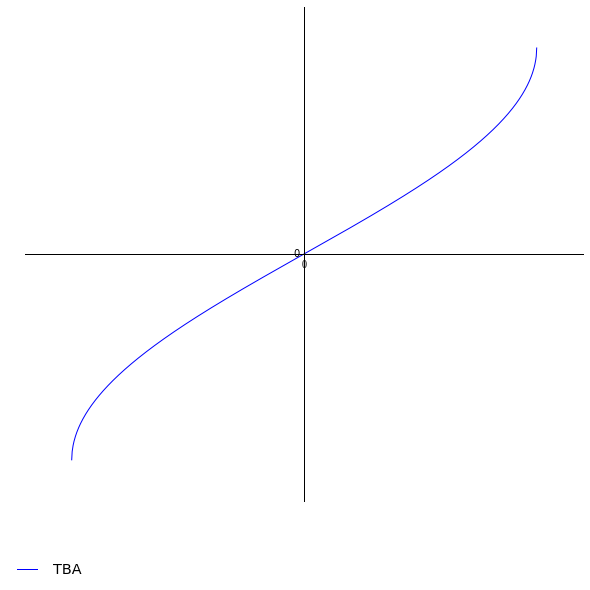

In [30]:
x = sp.symbols('x', real=True)
# mygraph = graph(fn=-2*x**2 + 5*x + 7)
# mygraph = graph(fn=sp.sin(x))
# mygraph = graph(fn = 2*x-5)
# mygraph = graph(fn = 1/(x+1), domain_from=-10, domain_to=10, points_to_plot=1000)
# mygraph = graph(fn=sp.tan(x), domain_from=-10, domain_to=10, points_to_plot=1000)
# mygraph = graph(fn=sp.tan(sp.Rational(1,2) * x), domain_from=-10, domain_to=10, points_to_plot=1000)
# mygraph = graph(fn=5*sp.cos(sp.Rational(2,2) * x), domain_from=-10, domain_to=10, points_to_plot=1000) # , x_tick_mark_type = 'degrees'
# mygraph = graph(fn=sp.Abs(x-3)-2, domain_from=-10, domain_to=10)
# mygraph = graph(fn = 5**(-x)-7)
# mygraph = graph(fn=5 * sp.cos(x), domain_from=-10, domain_to=10, points_to_plot=1000, x_tick_mark_type = 'radians')
mygraph = graph(fn = sp.acos(x), domain_from=-1, domain_to = 1)
mygraph = graph(fn = sp.asin(x), domain_from=-1, domain_to = 1)

mygraph.display()

In [5]:
sp.latex(sp.deg(mygraph.x_intercepts_sympy_rationals[0]))

'\\frac{180}{\\pi}'

In [6]:
solution_list = list(sp.solveset(mygraph.fn,x, domain=mygraph.domain_set))
first_item = solution_list[0]
# type(sp.print_latex(first_item))
sp.latex((first_item))

'1'

In [10]:
max(mygraph._y_plots())

3.141592653589793